# Based on our custom MIMIC language model, train a classifier

Make sure mimic_nlp_lm has been run first and sucessfully completed. That notebook builds the language model that allows classificiation to occur efficiently.

## Create a classifier to predict Length of Stay (LOS)

Steps:
1. Load clinical Notes
1. Load Admissions data
1. Calculate Length of Stay
1. Join Admissions data with Notes data (on HADM_ID) - Columns needed for classifier: LOS, TEXT

Would also be nice to see a graphical summary of LOS.

In [1]:
from fastai.text import *
from sklearn.model_selection import train_test_split
import glob
import gc
import altair as alt

Setup filenames and paths

In [2]:
# pandas doesn't understand ~, so provide full path
base_path = Path.home() / 'mimic'

# files used during processing - all aggregated here
admissions_file = base_path/'ADMISSIONS.csv'
notes_file = base_path/'NOTEEVENTS.csv'

class_file = 'los_cl_data.pickle'
notes_pickle_file = base_path/'noteevents.pickle'
lm_file = 'mimic_lm.pickle' # actual file is at base_path/lm_file but due to fastai function, have to pass file name separately
init_model_file = base_path/'los_cl_head'
cycles_file = base_path/'los_cl_num_iterations.pickle'
enc_file = 'mimic_fine_tuned_enc'
ft_file = 'los_cl_fine_tuned_'
freeze_two = base_path/'los_cl_freeze_two'
freeze_three = base_path/'los_cl_freeze_three'

training_history_file = 'los_cl_history'

Setup parameters for models

In [3]:
# original data set too large to work with in reasonable time due to limted GPU resources
pct_data_sample = 0.1
# how much to hold out for validation
valid_pct = 0.2
# for repeatability - different seed than used with language model
seed = 1776
# for classifier, on unfrozen/full network training
# batch size of 128 GPU uses ?? GB RAM
# batch size of 96 GPU uses 22 GB RAM
# batch size of 48 GPU uses GB RAM
bs=96

In [4]:
# if this doesn't free memory, can restart Python kernel.
# if that still doesn't work, try OS items mentioned here: https://docs.fast.ai/dev/gpu.html
def release_mem():
    gc.collect()
    torch.cuda.empty_cache()
release_mem()

In [5]:
orig_df = pd.DataFrame()
if os.path.isfile(notes_pickle_file):
    print('Loading noteevent pickle file')
    orig_df = pd.read_pickle(notes_pickle_file)
    print(orig_df.shape)
else:
    print('Could not find noteevent pickle file; creating it')
    # run this the first time to covert CSV to Pickle file
    orig_df = pd.read_csv(notes_file, low_memory=False, memory_map=True)
    orig_df.to_pickle(notes_pickle_file)

Loading noteevent pickle file
(2083180, 11)


Since seed is different, this should be quite different than the language model dataset.

Should I show details on how many records are in language model dataset?

In [6]:
notes_df = orig_df[orig_df.HADM_ID.notnull()].copy()
notes_df.HADM_ID = notes_df.HADM_ID.astype(int)
notes_df.shape

(1851344, 11)

In [7]:
notes_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [8]:
print('Loading ADMISSIONS.csv')
a_orig = pd.read_csv(admissions_file, low_memory=False, memory_map=True)
a_orig.shape

Loading ADMISSIONS.csv


(58976, 19)

In [9]:
a_df = a_orig[['HADM_ID', 'ADMITTIME', 'DISCHTIME']].copy()
#pd.to_datetime('2014-04-09T152959.999993-0500', utc=True)
# passing format just to make sure conversion doesn't mess something up
a_df['admittime'] = pd.to_datetime(a_df.ADMITTIME, format='%Y-%m-%d %H:%M:%S')
a_df['dischtime'] = pd.to_datetime(a_df.DISCHTIME, format='%Y-%m-%d %H:%M:%S')
a_df['los'] = (a_df['dischtime'] - a_df['admittime']).astype('timedelta64[D]')
# can't use a float in neural network
a_df['los'] = a_df.los.astype(int)
# there are 98 admissions where length of stay is negative. change to 0
a_df.loc[a_df.los < 0, 'los'] = 0
a_df.head()

,HADM_ID,ADMITTIME,DISCHTIME,admittime,dischtime,los
0,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,2196-04-09 12:26:00,2196-04-10 15:54:00,1
1,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,2153-09-03 07:15:00,2153-09-08 19:10:00,5
2,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,2157-10-18 19:34:00,2157-10-25 14:00:00,6
3,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,2139-06-06 16:14:00,2139-06-09 12:48:00,2
4,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,2160-11-02 02:06:00,2160-11-05 14:55:00,3


### Histogram of Length of Stay

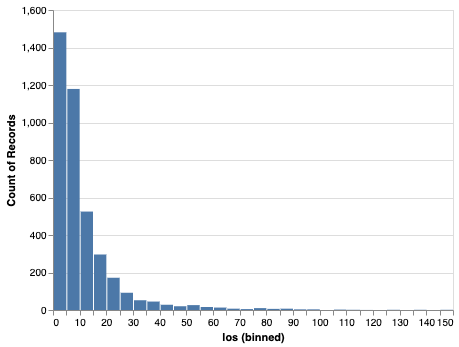

In [10]:
alt.Chart(a_df.head(4000)).mark_bar().encode(
    alt.X('los',
         bin=alt.BinParams(maxbins=50)),
    y='count()',
)

In [11]:
# make sure we only keep rows with notes
combined_df = pd.merge(a_df, notes_df, on='HADM_ID', how='right')

# passing format just to make sure conversion doesn't mess something up
combined_df['charttime'] = pd.to_datetime(combined_df.CHARTTIME, format='%Y-%m-%d %H:%M:%S')
combined_df['chartdate'] = pd.to_datetime(combined_df.CHARTDATE, format='%Y-%m-%d')
combined_df['admitdate'] = combined_df.admittime.dt.date
combined_df = combined_df[['HADM_ID', 'ROW_ID', 'admittime', 'admitdate', 'dischtime', 'los', 'chartdate', 'charttime', 'TEXT']]
combined_df.rename(columns={'HADM_ID': 'hadm_id', 'ROW_ID': 'row_id', 'TEXT': "text"}, inplace=True)
combined_df.shape

(1851344, 9)

In [12]:
# these should all be zero
print(combined_df[combined_df.los.isnull()].shape)
print(combined_df[combined_df.hadm_id.isnull()].shape)
print(combined_df[combined_df.text.isnull()].shape)

(0, 9)
(0, 9)
(0, 9)


In [13]:
combined_df.head()

,hadm_id,row_id,admittime,admitdate,dischtime,los,chartdate,charttime,text
0,165315,12144,2196-04-09 12:26:00,2196-04-09,2196-04-10 15:54:00,1,2196-04-10,NaT,Admission Date: [**2196-4-9**] Discharg...
1,165315,158364,2196-04-09 12:26:00,2196-04-09,2196-04-10 15:54:00,1,2196-04-09,NaT,Normal sinus rhythm. Non-diagnostic repolariza...
2,165315,158365,2196-04-09 12:26:00,2196-04-09,2196-04-10 15:54:00,1,2196-04-09,NaT,Normal sinus rhythm without diagnostic abnorma...
3,165315,754366,2196-04-09 12:26:00,2196-04-09,2196-04-10 15:54:00,1,2196-04-10,2196-04-10 23:52:00,[**2196-4-10**] 11:52 PM\n CHEST (PORTABLE AP)...
4,165315,754332,2196-04-09 12:26:00,2196-04-09,2196-04-10 15:54:00,1,2196-04-09,2196-04-09 10:19:00,[**2196-4-9**] 10:19 AM\n CT HEAD W/O CONTRAST...


In [14]:
len(combined_df.hadm_id.unique())

58361

### Use notes from day 1 of stay to predict LOS


    For each admission
        do they have notes on day 1 of stay


In [15]:
combined_df.dtypes

hadm_id               int64
row_id                int64
admittime    datetime64[ns]
admitdate            object
dischtime    datetime64[ns]
los                   int64
chartdate    datetime64[ns]
charttime    datetime64[ns]
text                 object
dtype: object

In [16]:
# Just look at one admission to see if this is the right filter criteria
combined_df[combined_df.hadm_id == 100006].sort_values(['chartdate', 'charttime'])

,hadm_id,row_id,admittime,admitdate,dischtime,los,chartdate,charttime,text
305523,100006,783338,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-06,2108-04-06 11:45:00,[**2108-4-6**] 11:45 AM\n CHEST (PORTABLE AP) ...
305532,100006,1392730,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-06,2108-04-06 18:04:00,PMICU Nursing Progress Notet 1630-1900\n\nPlea...
305519,100006,148403,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-06,NaT,Sinus tachycardia\nLeft axis deviation - anter...
305535,100006,1392731,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-07,2108-04-07 04:01:00,Resp Care\nPt. appeared very uncomfortable @ s...
305536,100006,1392732,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-07,2108-04-07 05:07:00,7p to 7a Micu Progress Note\n\nNeuro - Remains...
305537,100006,1392733,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-07,2108-04-07 18:06:00,NARRATIVE NURSING NOTE\nRESP: PT HAS HAD 2 EPI...
305533,100006,1392734,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-08,2108-04-08 05:09:00,7p to 7a Micu Progress Note\n\nNeuro - Alert a...
305534,100006,1392735,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-08,2108-04-08 16:48:00,NARRATIVE NURSING NOTE:\nRESP; PT WITH EXP WHE...
305526,100006,1392736,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-09,2108-04-09 05:09:00,7p to 7a Micu Progress Note\n\nNeuro - Alert a...
305527,100006,1392737,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-09,2108-04-09 06:30:00,Addendum - Pt increasingly fatigued appearing ...


In [17]:
# Just look at one admission to see if this is the right filter criteria
h = 100006
#for h in combined_df.HADM_ID.unique():
combined_df[(combined_df.hadm_id == h) & 
            (combined_df.charttime >= combined_df.admittime) &
            (combined_df.charttime < (combined_df.admittime + pd.Timedelta(hours=24)))
           ]

,hadm_id,row_id,admittime,admitdate,dischtime,los,chartdate,charttime,text
305532,100006,1392730,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-06,2108-04-06 18:04:00,PMICU Nursing Progress Notet 1630-1900\n\nPlea...
305535,100006,1392731,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-07,2108-04-07 04:01:00,Resp Care\nPt. appeared very uncomfortable @ s...
305536,100006,1392732,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-07,2108-04-07 05:07:00,7p to 7a Micu Progress Note\n\nNeuro - Remains...


In [18]:
# Just look at one admission to see if this is the right filter criteria
h = 100006
#for h in combined_df.HADM_ID.unique():
combined_df[(combined_df.hadm_id == h) & 
            (((combined_df.charttime >= combined_df.admittime) &
            (combined_df.charttime < (combined_df.admittime + pd.Timedelta(hours=24))))
             |
            (combined_df.chartdate == combined_df.admitdate))
           ]

,hadm_id,row_id,admittime,admitdate,dischtime,los,chartdate,charttime,text
305519,100006,148403,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-06,NaT,Sinus tachycardia\nLeft axis deviation - anter...
305523,100006,783338,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-06,2108-04-06 11:45:00,[**2108-4-6**] 11:45 AM\n CHEST (PORTABLE AP) ...
305532,100006,1392730,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-06,2108-04-06 18:04:00,PMICU Nursing Progress Notet 1630-1900\n\nPlea...
305535,100006,1392731,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-07,2108-04-07 04:01:00,Resp Care\nPt. appeared very uncomfortable @ s...
305536,100006,1392732,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12,2108-04-07,2108-04-07 05:07:00,7p to 7a Micu Progress Note\n\nNeuro - Remains...


### Histogram of note count each patient has

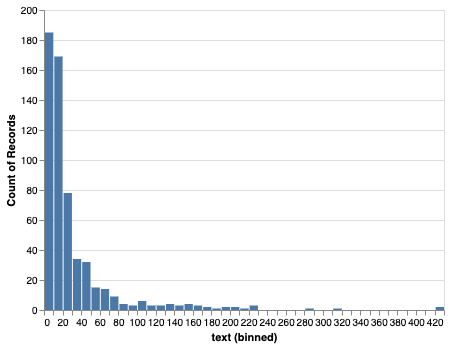

In [19]:
alt.Chart(
    combined_df.groupby('hadm_id', as_index=False).text.count().sample(frac=.01, random_state=seed)
).mark_bar().encode(
    alt.X('text', bin=alt.BinParams(maxbins=50)),
    y='count()',
)

### Scatter plot of Number of Notes vs Length of Stay

In [20]:
combined_df[['hadm_id', 'los']].drop_duplicates().shape
combined_df.groupby('hadm_id', as_index=False).text.count().shape  #58,361

(58361, 2)

In [21]:
los_v_num_notes = pd.merge(combined_df[['hadm_id', 'los']].drop_duplicates(), 
          combined_df.groupby('hadm_id', as_index=False).text.count(),
          on='hadm_id')
los_v_num_notes.shape

(58361, 3)

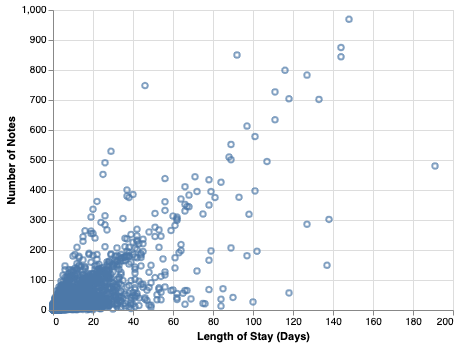

In [22]:
alt.Chart(los_v_num_notes.sample(frac=.08, random_state=seed)).mark_point().encode(
    x=alt.X('los', axis=alt.Axis(title='Length of Stay (Days)')),
    y=alt.Y('text', axis=alt.Axis(title='Number of Notes')))

### Build data set for LOS analysis

First, find rows of data related to first day of stay

Then, combine notes from first day into one text field

In [23]:
# this is the slowest cell in pre-processing portion of the notebook 
fday = combined_df.groupby('hadm_id', as_index=False).apply(lambda g: g[
    (g.charttime >= g.admittime) & (g.charttime < (g.admittime + pd.Timedelta(hours=24)))
    |
    (g.chartdate == g.admitdate)
])

In [24]:
fday.head()

hadm_id   row_id           admittime   admitdate  \
0 1523431   100001  1206584 2117-09-11 11:46:00  2117-09-11   
1 1512590   100003   193462 2150-04-17 15:34:00  2150-04-17   
  1512591   100003   567670 2150-04-17 15:34:00  2150-04-17   
  1512592   100003   567662 2150-04-17 15:34:00  2150-04-17   
  1512596   100003   567564 2150-04-17 15:34:00  2150-04-17   

                    dischtime  los  chartdate           charttime  \
0 1523431 2117-09-17 16:45:00    6 2117-09-11 2117-09-11 11:12:00   
1 1512590 2150-04-21 17:30:00    4 2150-04-17                 NaT   
  1512591 2150-04-21 17:30:00    4 2150-04-18 2150-04-18 11:53:00   
  1512592 2150-04-21 17:30:00    4 2150-04-18 2150-04-18 02:47:00   
  1512596 2150-04-21 17:30:00    4 2150-04-17 2150-04-17 20:48:00   

                                                        text  
0 1523431  [**2117-9-11**] 11:12 AM\n CHEST (PA & LAT)   ...  
1 1512590  Sinus rhythm\nProlonged QT interval is nonspec...  
  1512591  59 year old male with HCV-related cirrhosis, g...  
  1512592  Chief Complaint:  coffee ground emesis, light ...  
  1512596  Chief Complaint:  GIB/HOTN\n   I saw and exami...

In [25]:
tmp = fday[['hadm_id', 'row_id']].reset_index(drop=True)
tmp['row_id'] = tmp['row_id'].astype(str)
tmp.dtypes

hadm_id     int64
row_id     object
dtype: object

In [26]:
tmp.head()

,hadm_id,row_id
0,100001,1206584
1,100003,193462
2,100003,567670
3,100003,567662
4,100003,567564


In [27]:
combined_notes_row_ids = tmp.groupby(['hadm_id'], as_index=False).agg({
    'row_id': lambda x: ",".join(x)
})
combined_notes_row_ids.head()

,hadm_id,row_id
0,100001,1206584
1,100003,"193462,567670,567662,567564,567651,567608,5676..."
2,100006,"148403,783338,1392730,1392731,1392732"
3,100007,"281959,1563229,1563230"
4,100009,"185962,1189514,1189544"


In [28]:
fday.head()

hadm_id   row_id           admittime   admitdate  \
0 1523431   100001  1206584 2117-09-11 11:46:00  2117-09-11   
1 1512590   100003   193462 2150-04-17 15:34:00  2150-04-17   
  1512591   100003   567670 2150-04-17 15:34:00  2150-04-17   
  1512592   100003   567662 2150-04-17 15:34:00  2150-04-17   
  1512596   100003   567564 2150-04-17 15:34:00  2150-04-17   

                    dischtime  los  chartdate           charttime  \
0 1523431 2117-09-17 16:45:00    6 2117-09-11 2117-09-11 11:12:00   
1 1512590 2150-04-21 17:30:00    4 2150-04-17                 NaT   
  1512591 2150-04-21 17:30:00    4 2150-04-18 2150-04-18 11:53:00   
  1512592 2150-04-21 17:30:00    4 2150-04-18 2150-04-18 02:47:00   
  1512596 2150-04-21 17:30:00    4 2150-04-17 2150-04-17 20:48:00   

                                                        text  
0 1523431  [**2117-9-11**] 11:12 AM\n CHEST (PA & LAT)   ...  
1 1512590  Sinus rhythm\nProlonged QT interval is nonspec...  
  1512591  59 year old male with HCV-related cirrhosis, g...  
  1512592  Chief Complaint:  coffee ground emesis, light ...  
  1512596  Chief Complaint:  GIB/HOTN\n   I saw and exami...

In [29]:
combined_fday = fday.groupby(['hadm_id', 'los'], as_index=False).agg({
    'text': lambda x: "\n\n\n\n".join(x)
})

In [30]:
combined_fday.head()

,hadm_id,los,text
0,100001,6,[**2117-9-11**] 11:12 AM\n CHEST (PA & LAT) ...
1,100003,4,Sinus rhythm\nProlonged QT interval is nonspec...
2,100006,12,Sinus tachycardia\nLeft axis deviation - anter...
3,100007,7,Sinus rhythm\nAtrial premature complex\nConsid...
4,100009,4,Sinus bradycardia. Left atrial abnormality. ...


In [31]:
combined_fday.shape

(55353, 3)

In [32]:
len(combined_fday.los.unique())

159

In [33]:
print(combined_fday.los.value_counts().head(10))
print(combined_fday.los.value_counts().tail(10))

4    5686
2    5389
3    4863
5    4554
6    4001
7    3503
1    3257
8    2825
9    2392
0    2062
Name: los, dtype: int64
150    1
181    1
140    1
109    1
163    1
141    1
136    1
173    1
206    1
191    1
Name: los, dtype: int64


In [34]:
s = combined_fday.los.value_counts()
print('Number of records where length of stay is unique to that person:', len(s[s == 1]))

Number of records where length of stay is unique to that person: 23


In [35]:
# min
print('Min LOS:', combined_fday.los.min())
# max
print('Max LOS:', combined_fday.los.max())
# median
print('Median LOS:', combined_fday.los.median())
# mean
print('Mean LOS:', combined_fday.los.mean())
print('Mode LOS:', combined_fday.los.mode()[0]) # returns a series, just want the value

Min LOS: 0
Max LOS: 206
Median LOS: 6.0
Mean LOS: 9.581088649215038
Mode LOS: 4


### Truncate LOS to max of 10

In [36]:
trunc_fday = combined_fday.copy()
trunc_fday.loc[trunc_fday.los > 9, 'los'] = 10
trunc_fday.head()

,hadm_id,los,text
0,100001,6,[**2117-9-11**] 11:12 AM\n CHEST (PA & LAT) ...
1,100003,4,Sinus rhythm\nProlonged QT interval is nonspec...
2,100006,10,Sinus tachycardia\nLeft axis deviation - anter...
3,100007,7,Sinus rhythm\nAtrial premature complex\nConsid...
4,100009,4,Sinus bradycardia. Left atrial abnormality. ...


In [37]:
s = trunc_fday.los.value_counts()
len(s[s == 1])

0

In [38]:
print(trunc_fday.los.value_counts().head(15))

10    16821
4      5686
2      5389
3      4863
5      4554
6      4001
7      3503
1      3257
8      2825
9      2392
0      2062
Name: los, dtype: int64


In [39]:
rowid_sample = combined_notes_row_ids.sample(frac=pct_data_sample, random_state=seed)

In [40]:
df = trunc_fday.sample(frac=pct_data_sample, random_state=seed)
df.shape

(5535, 3)

In [41]:
# should be 5535 - 100% overlap
len(set(rowid_sample.hadm_id.unique()) & set(df.hadm_id.unique()))

5535

In [42]:
len(df.hadm_id.unique())

5535

In [43]:
print('--------- stats on 10% random sample ---------')
print('Min LOS:', df.los.min())
print('Max LOS:', df.los.max())
print('Median LOS:', df.los.median())
print('Mean LOS:', df.los.mean())
print('Mode LOS:', df.los.mode()[0]) # returns a series, just want the value

--------- stats on 10% random sample ---------
Min LOS: 0
Max LOS: 10
Median LOS: 6.0
Mean LOS: 5.998193315266486
Mode LOS: 10


In [44]:
#s.apply(pd.Series).stack().reset_index(drop=True)

r = rowid_sample.groupby(['hadm_id'], as_index=False).agg({
    'row_id': lambda x: x.str.split(',')
})
row_ids = r.row_id.apply(pd.Series).stack().reset_index(drop=True)

In [45]:
print(row_ids.shape)         # 33,914
print(len(row_ids.unique())) # 33,914

(33914,)
33914


In [46]:
# compare overlap between these notes and language model notes set
lm_df = orig_df.sample(frac=pct_data_sample, random_state=42)
print('rows in dataframe for NN:', len(row_ids.unique()))
print('rows in language model:', len(lm_df.ROW_ID.unique()))
print('row_ids in both:', len(set(row_ids.unique()) & set(lm_df.ROW_ID.unique())))

rows in dataframe for NN: 33914
rows in language model: 208318
row_ids in both: 0


## Now for some Deep Learning

In [65]:
# What if LOS was a string? Would accuracy, memory, or training time change?
# after some testing - no
# df_test = df.copy()
# df_test.los = df_test.los.apply(str)
# df_test.dtypes

hadm_id     int64
los        object
text       object
dtype: object

In [48]:
if os.path.isfile(base_path/lm_file):
    print('loading existing language model')
    lm = load_data(base_path, lm_file, bs=bs)
else:
    print('ERROR: language model file not found.')

loading existing language model


#### This is a very CPU and RAM intensive process - no GPU involved

In [49]:
filename = base_path/class_file
if os.path.isfile(filename):
    data_cl = load_data(base_path, class_file, bs=bs)
    print('loaded existing data bunch')
else:
    # do I need a vocab here? test with and without...
    data_cl = (TextList.from_df(df, base_path, cols='text', vocab=lm.vocab)
               #df has several columns; actual text is in column TEXT
               .split_by_rand_pct(valid_pct=valid_pct, seed=seed)
               #We randomly split and keep 20% for validation, set seed for repeatability
               .label_from_df(cols='los')
               .databunch(bs=bs))
    data_cl.save(filename)
    print('created new data bunch')

created new data bunch


### Using weighted F1 to account for class imbalance

See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [50]:
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(average='weighted', beta=1)])
learn.load_encoder(enc_file)

In [51]:
# with P100/P40 this takes maybe 5 minutes
# with 2017 macbook pro, intel core i7 3.1Ghz, this takes about 160 minutes
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


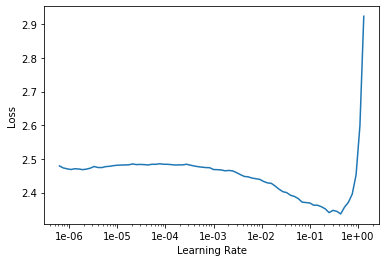

In [52]:
learn.recorder.plot()

Change learning rate based on results from the above plot.

Next several cells test various learning rates to find ideal learning rate

```python
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(average='weighted', beta=1)])
learn.load_encoder(enc_file)
learn.fit_one_cycle(1, 5e-1, moms=(0.8,0.7))
```

     epoch 	train_loss 	valid_loss 	accuracy 	f_beta 	time
        0	4.441254	2.457666	0.301716	0.174702	03:54

```python
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(average='weighted', beta=1)])
learn.load_encoder(enc_file)
learn.fit_one_cycle(1, 3e-1, moms=(0.8,0.7))
```

     epoch 	train_loss 	valid_loss 	accuracy 	f_beta 	time
        0	2.329859	2.146445	0.319783	0.154967	03:44

```python
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(average='weighted', beta=1)])
learn.load_encoder(enc_file)
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))
```

     epoch 	train_loss 	valid_loss 	accuracy 	f_beta 	time
        0	2.192971	2.083736	0.345077	0.211943	03:17

```python
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(average='weighted', beta=1)])
learn.load_encoder(enc_file)
learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))
```

     epoch 	train_loss 	valid_loss 	accuracy 	f_beta 	time
        0	2.183936	2.054368	0.359530	0.233471	03:56

```python
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(average='weighted', beta=1)])
learn.load_encoder(enc_file)
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
```

     epoch 	train_loss 	valid_loss 	accuracy 	f_beta 	time
        0	2.199809	2.068873	0.343270	0.217603	03:38

### Train with selected learning rate

Results from `learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))`

    Training new initial learner

    epoch 	train_loss 	valid_loss 	accuracy 	f_beta 	time
        0 	2.280483 	1.603017 	0.424571 	0.400360 	02:58


In [59]:
if os.path.isfile(str(init_model_file) + '.pth'):
    learn.load(init_model_file)
    print('loaded initial learner')
else:
    print('Training new initial learner')
    learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7),
                       callbacks=[
                           callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                       ])
    print('Saving new learner')
    learn.save(init_model_file)
    print('Finished generating new learner')

Training new initial learner


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.097782,2.028756,0.355917,0.230938,03:16


Saving new learner
Finished generating new learner


### Results from the freeze_two learner


With `learn.fit_one_cycle(1, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))`

    epoch 	train_loss 	valid_loss 	accuracy 	f_beta 	time
        0	2.151176	2.060364	0.368564	0.266202	04:06
        
With `learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))`

     epoch 	train_loss 	valid_loss 	accuracy 	f_beta 	time
        0	2.056317	2.013587	0.368564	0.245495	04:00
        
With `learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))`

    epoch	train_loss	valid_loss	accuracy	f_beta	time
        0	2.335549	2.178197	0.236676	0.157695	04:05
        
With `learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))`

     epoch 	train_loss 	valid_loss 	accuracy 	f_beta 	time
        0	2.529039	2.485589	0.075881	0.070762	03:26


In [79]:
if os.path.isfile(str(freeze_two) + '.pth'):
    learn.load(freeze_two)
    print('loaded freeze_two learner')
else:
    print('Training new freeze_two learner')
    learn.freeze_to(-2)
    learn.fit_one_cycle(1, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7),
                       callbacks=[
                           callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                       ])
    print('Saving new freeze_two learner')
    learn.save(freeze_two)
    print('Finished generating new freeze_two learner')

Training new freeze_two learner


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.072790,1.991389,0.372177,0.258272,03:48


Saving new freeze_two learner
Finished generating new freeze_two learner


In [80]:
learn.load(freeze_two)
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.010714,2.073426,0.373984,0.265069,04:21


In [81]:
learn.load(freeze_two)
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.941861,1.975329,0.369467,0.269504,03:50


In [82]:
learn.load(freeze_two)
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.958077,1.971695,0.367660,0.270906,03:51


In [ ]:
if os.path.isfile(str(freeze_three) + '.pth'):
    learn.load(freeze_three)
    print('loaded freeze_three learner')
else:
    print('Training new freeze_three learner')
    learn.freeze_to(-3)
    learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7),
                       callbacks=[
                           callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                       ])
    print('Saving new freeze_three learner')
    learn.save(freeze_three)
    print('Finished generating new freeze_three learner')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
release_mem()

In [ ]:
if os.path.isfile(cycles_file):
    with open(cycles_file, 'rb') as f:
        prev_cycles = pickle.load(f)
    print('This model has been trained for', prev_cycles, 'epochs already')  
else:
    prev_cycles = 0
    print('This model NOT been trained yet') 

In [ ]:
num_cycles = 7

file = ft_file + str(prev_cycles)
learner_file = base_path/file
callback_save_file = str(learner_file) + '_auto'

learn.fit_one_cycle(num_cycles, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7),
                    callbacks=[
                        callbacks.SaveModelCallback(learn, every='epoch', monitor='accuracy', name=callback_save_file),
                        # CSVLogger only logs when num_cycles are complete
                        callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                    ])
file = ft_file + str(prev_cycles + num_cycles)
learner_file = base_path/file
learn.save(learner_file)

with open(cycles_file, 'wb') as f:
    pickle.dump(num_cycles + prev_cycles, f)
release_mem()